# Benchmark different QBMs

In [1]:
"""
Benchmark a QBM on the Hamiltonian dataset
"""
import numpy as np

##########
# CONFIG #
##########

rng = np.random.default_rng(seed=1)

n_qubits = 5
model_label = 0 # 0: 1D TFIM 1: 1D Heisenberg
depolarizing_noise = 0.0 # if noisy expectation values
learning_rate = 0.2
epochs = 1000
eps = 1e-6
compute_qre = True



In [3]:
from qbm_quimb import hamiltonians, data

########
# DATA #
########

# As an example, the Gibbs state of TF-Ising model (label=0)
# is taken to generate data (expectation values)
target_label = 0
target_params = np.array([4.0, 4.0])
target_beta = 2.0

# A list of operators in the model Hamiltonian
model_ham_ops = hamiltonians.hamiltonian_operators(n_qubits, model_label)
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    model_ham_ops,
    depolarizing_noise,
)


In [4]:
from qbm_quimb import training
from qbm_quimb.training import QBM


#############
# QBM Model #
#############

initial_params = rng.normal(size=len(model_ham_ops))
qbm_state = QBM(model_ham_ops, initial_params)
print(f"Initial parameters: {qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")

################
# QBM Taininig #
################

target_eta = None
if compute_qre:
    target_eta = target_state

qbm_state, max_grads_hist, qre_hist = training.train_qbm(
    qbm=qbm_state,
    target_expects=target_expects,
    learning_rate=learning_rate,
    epochs=epochs,
    eps=eps,
    compute_qre=compute_qre,
    target_eta=target_eta,
)


Initial parameters: [0.34558419 0.82161814]
Target parameters: [4. 4.]
Target beta: 2.0


In [5]:
print(f"Trained parameters: {qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")
if compute_qre:
    print(f"Initial relative entropy: {qre_hist[0]}")
    print(f"Trained relative entropy: {qre_hist[-1]}")


Trained parameters: [-5.60380221 -5.6882359 ]
Max. gradients: 0.007315590965829788
Initial relative entropy: 9.104425512098278
Trained relative entropy: 0.013577910443352437


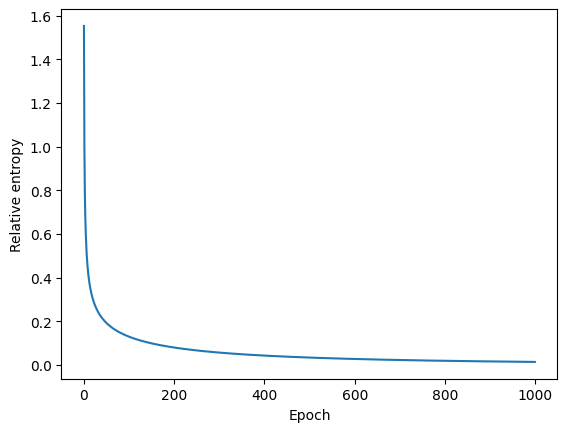

In [6]:
import matplotlib.pyplot as plt

if compute_qre:
    plt.plot(qre_hist[1:], "-")
    plt.xlabel("Epoch")
    plt.ylabel("Relative entropy")
    plt.show()


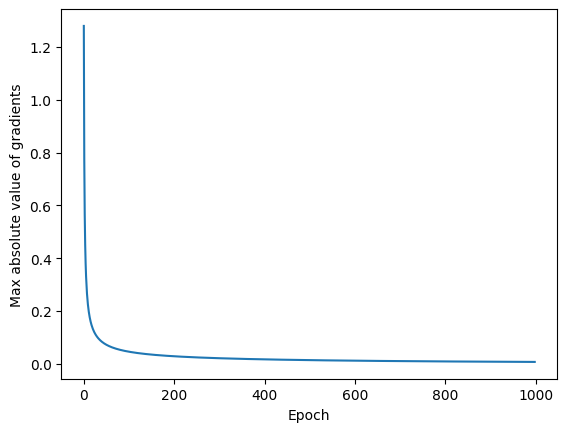

In [7]:
plt.plot(max_grads_hist[1:], "-")
plt.xlabel("Epoch")
plt.ylabel("Max absolute value of gradients")
plt.show()